# __Machine Learning for Prioritizing Blood Pressure Genes__ 

In [1]:
import re

import numpy as np
import pandas as pd
from numpy import sort

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

import seaborn as sns
import shap
import statsmodels.api as sm

%matplotlib inline
%config InlineBackend.figure_format ='retina'
import statsmodels.stats.api as sms
from xgboost import XGBRegressor
import sys
import sklearn.neighbors._base  
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from sklearn import datasets, metrics, model_selection, preprocessing
from sklearn.metrics import (
    explained_variance_score,
    max_error,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    RepeatedKFold,
    cross_val_predict,
    cross_val_score,
    cross_validate,
    learning_curve,
    train_test_split,
    validation_curve,
)

sns.set_style("darkgrid")
sns.mpl.rcParams["figure.figsize"] = (15.0, 9.0)

import warnings

import matplotlib
import matplotlib.pyplot as plt

warnings.simplefilter(action="ignore", category=FutureWarning)
from warnings import filterwarnings

filterwarnings("ignore")

seed = 0

In [2]:
data = pd.read_csv("training_cleaned.csv", header=0, sep=",")

In [3]:
data["label_encoded"] = data["label"].map(
    {"most likely": 1, "probable": 0.75, "least likely": 0.1}
)
Y = data["label_encoded"]
data = data.drop(["label"], 1)
data.shape

(804, 29)

### Load Boruta Shap Selected Features

In [4]:
X = pd.read_csv("selected_features_training_data.csv", header=0)
X.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X.columns.values
]

In [5]:
df_gene = data[["Gene"]]

X = pd.concat([df_gene, X], axis=1)

X = X.set_index("Gene")

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

### Optimized Model:
- XGB (gradient boosting regression) model with set parameters used for the rest of the code

In [7]:
XGB = XGBRegressor(learning_rate=0.2, max_depth=3, n_estimators=50, random_state=seed, reg_alpha=1, reg_lambda=6)

### Training Data Prediction Visualization:

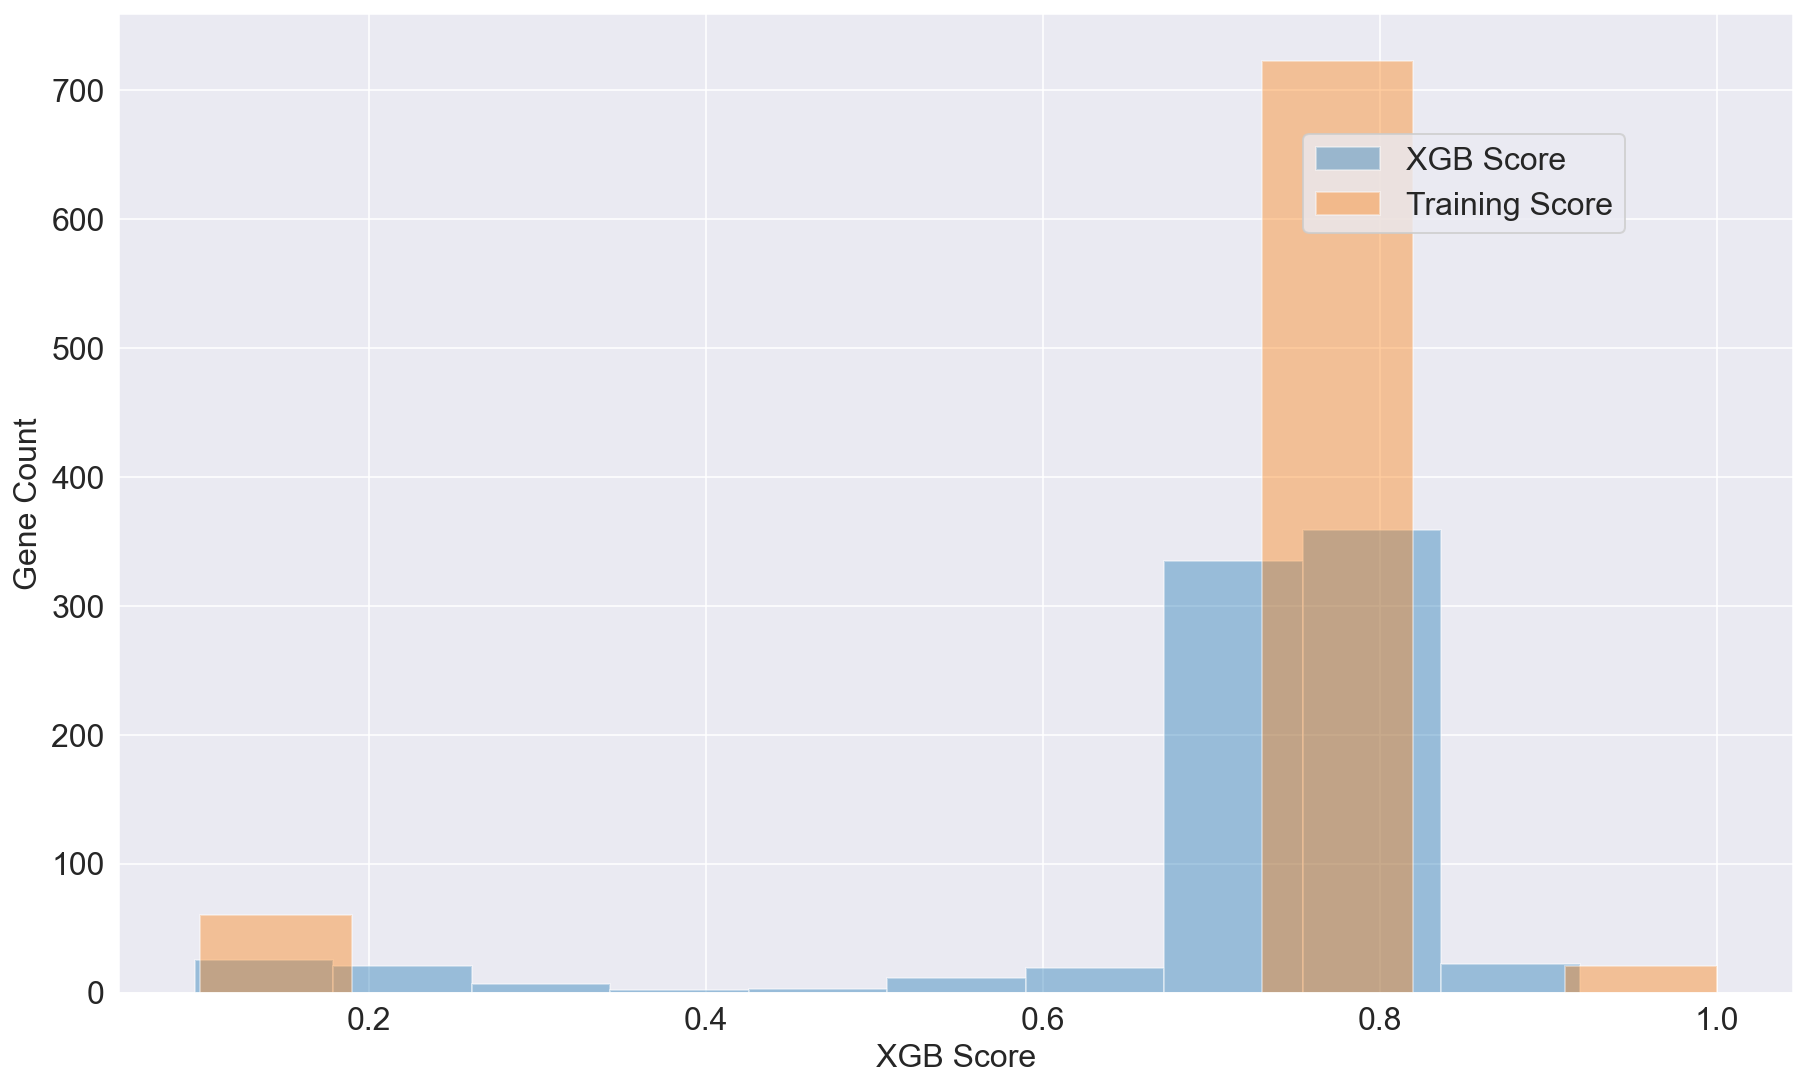

In [8]:
XGB.fit(X, Y)
predictions = list(XGB.predict(X))

output = pd.Series(data=predictions, index=X.index, name="XGB_Score")

df_total_training = pd.concat([X, output], axis=1)

df_total = pd.concat([X, output], axis=1)

fig, ax = plt.subplots()

sns.distplot(df_total["XGB_Score"], ax=ax, kde=False, norm_hist=False, bins=10)
sns.distplot(Y, ax=ax, kde=False, bins=10)
fig.legend(
    labels=["XGB Score", "Training Score"],
    loc="upper right",
    bbox_to_anchor=(0.83, 0.8),
    ncol=1,
    fontsize=16,
)
ax.set_xlabel("XGB Score", fontsize=16)
ax.set_ylabel("Gene Count", fontsize=16)
ax.tick_params(labelsize=16)

In [9]:
predictions = list(XGB.predict(X))

output = pd.Series(data=predictions, index=X.index, name="XGB_Score")

output = output.to_frame()
output.reset_index(level=0, inplace=True)

In [10]:
df_b = data[["label_encoded"]]

df_c = pd.concat([output, df_b], axis=1)
df_c.to_csv("XGB_training.csv", index=False)
df_c

,Gene,XGB_Score,label_encoded
0,ABCA1,0.903607,1.00
1,ABCA12,0.653414,0.75
2,ABCA2,0.696213,0.75
3,ABCA3,0.765888,0.75
4,ABCA7,0.739877,0.75
...,...,...,...
799,ZFP91,0.685715,0.75
800,ZFYVE28,0.761151,0.75
801,ZNF32,0.734938,0.75
802,ZNF664,0.733603,0.75


## Overview of SHAP feature importance:
- Further invesitgation into SHAP visualization of training data continued in the next script (SHAP_Random-Forest-BPGWASPredict.ipynb)

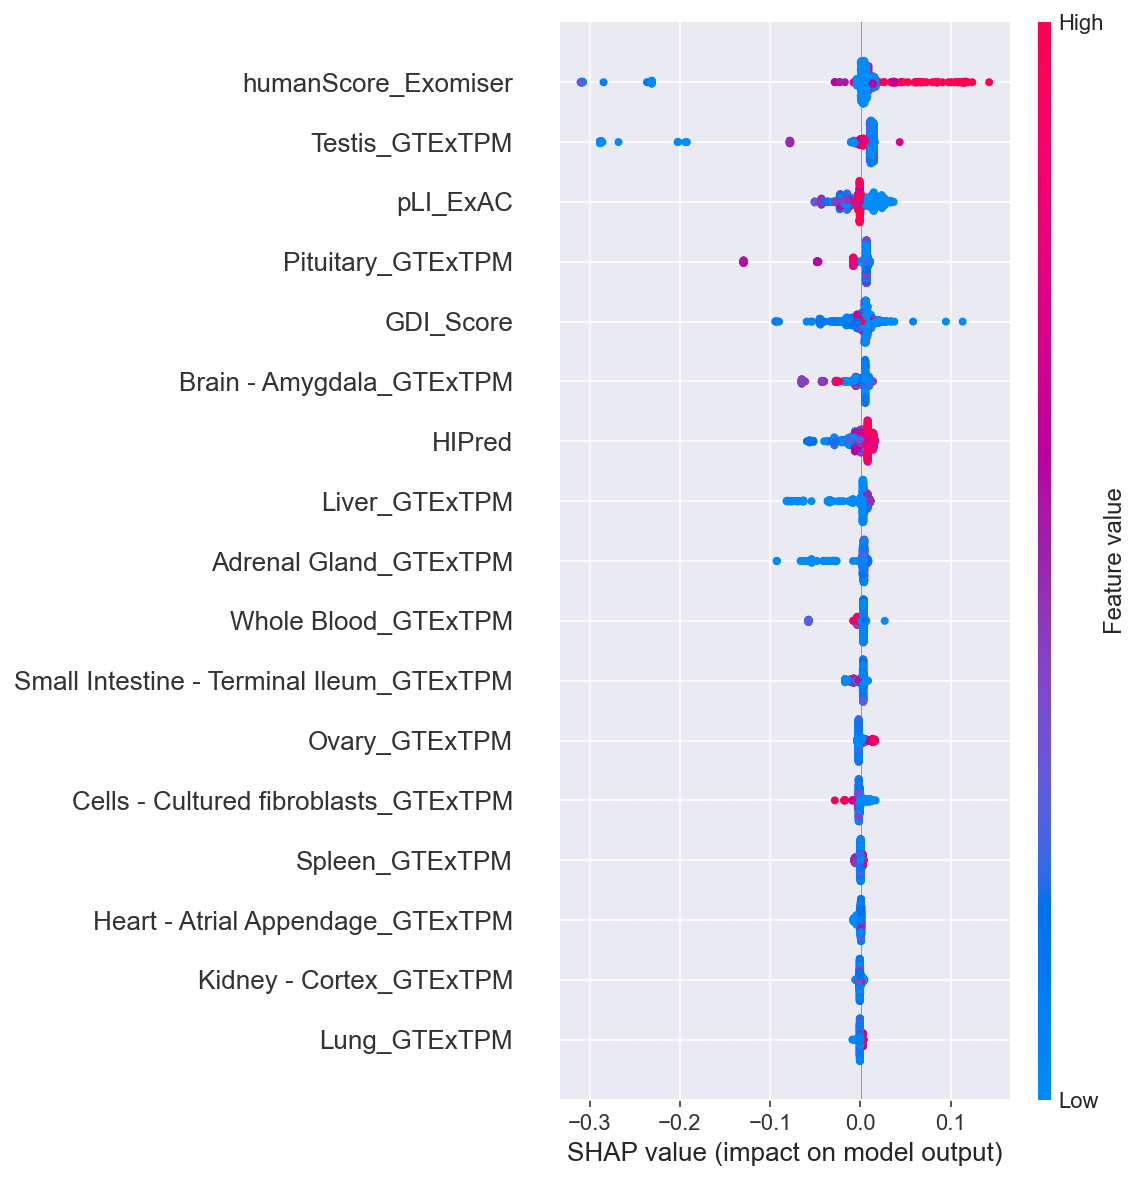

In [11]:
XGB.fit(X, Y)
explainer = shap.TreeExplainer(XGB)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

### Unknown gene prediction by the trained model:

In [12]:
dataset_unknown = pd.read_csv("lipids_predicted_alltypes.txt", sep=",")
dataset_unknown = dataset_unknown[~dataset_unknown.loc[:,'Gene'].isin(df_c['Gene'])]
df2 = dataset_unknown[
    [
       'Cells - Cultured fibroblasts_GTExTPM', 'Heart - Atrial Appendage_GTExTPM', 'Adrenal Gland_GTExTPM', 
        'Testis_GTExTPM', 'humanScore_Exomiser', 'pLI_ExAC', 'GDI_Score', 'Lung_GTExTPM', 'HIPred',
        'Whole Blood_GTExTPM', 'Ovary_GTExTPM', 'Spleen_GTExTPM', 'Kidney - Cortex_GTExTPM', 
        'Pituitary_GTExTPM', 'Small Intestine - Terminal Ileum_GTExTPM', 'Liver_GTExTPM', 'Brain - Amygdala_GTExTPM'
    ]
]

df2.shape

(52981, 17)

In [13]:
imputer = MissForest(random_state=seed)
df3 = imputer.fit_transform(df2)

Iteration: 0
Iteration: 1
Iteration: 2


In [14]:
X2 = pd.DataFrame(df3, index=df2.index, columns=df2.columns)
X2.shape

(52981, 17)

In [15]:
model = XGB
model.fit(X, Y)
predictions = list(model.predict(X2))

output = pd.Series(data=predictions, index=dataset_unknown.index, name="XGB_Score")

df_total = pd.concat([dataset_unknown, output], axis=1)

In [16]:
df_total.nlargest(10, "XGB_Score", keep="last")

,Gene,logpval_gwascatalog,gwastrait,Adipose - Subcutaneous_GTExTPM,Adipose - Visceral (Omentum)_GTExTPM,Adrenal Gland_GTExTPM,Artery - Aorta_GTExTPM,Artery - Coronary_GTExTPM,Artery - Tibial_GTExTPM,Bladder_GTExTPM,...,H3k79me2_count,SignalValue_H3k79me2_median,H3k9ac_count,SignalValue_H3k9ac_median,H3k9me1_count,SignalValue_H3k9me1_median,H4k20me1_count,SignalValue_H4k20me1_median,Type,XGB_Score
9748,CPT2,17.698970,Metabolite levels,9.31884,7.79499,19.78130,6.21717,8.39610,7.22357,11.95930,...,22.0,5.84735,19.0,28.03450,36.0,1.24644,36.0,1.27336,protein_coding,0.898447
18477,KHK,7.000000,Self-reported risk-taking behaviour,3.65354,3.09637,6.62790,5.36107,4.50676,4.85107,3.26127,...,NaN,NaN,15.0,4.31351,12.0,1.29391,NaN,NaN,protein_coding,0.895399
16140,HADH,11.301030,Hair color,48.48460,50.85610,31.54400,40.73000,32.19850,45.62760,29.65600,...,111.0,3.76167,18.0,26.50480,128.0,1.31853,128.0,1.20189,protein_coding,0.894331
4115,ACAD9,NaN,NaN,26.89630,24.87410,28.14650,27.04060,26.91230,26.34930,26.69690,...,165.0,6.58270,26.0,46.63550,23.0,5.57097,99.0,1.58794,protein_coding,0.892422
15481,GLYCTK,9.301030,Total testosterone levels,14.08280,15.08890,9.29844,5.68484,7.81951,3.83173,9.06708,...,39.0,7.14453,14.0,34.87620,NaN,NaN,9.0,2.52830,protein_coding,0.892334
47552,SORD,5.698970,Alzheimer's disease in APOE e4+ carriers,2.25736,2.09898,13.08310,3.98714,3.14645,2.45029,4.60713,...,87.0,5.98427,15.0,17.63600,63.0,1.24083,3.0,1.98173,protein_coding,0.891242
4114,ACAD8,7.221849,"Obesity-related traits, Obesity-related traits...",19.37270,17.56260,23.76700,18.28890,18.84340,16.28370,21.63960,...,22.0,4.27235,19.0,12.29920,39.0,1.30881,37.0,1.60550,protein_coding,0.890940
46236,SLC29A3,7.698970,"Systemic lupus erythematosus, Diisocyanate-ind...",7.41433,6.13122,3.38742,6.05204,6.42649,5.19343,10.85830,...,NaN,NaN,48.0,22.17540,190.0,1.19302,NaN,NaN,protein_coding,0.886970
4562,AGL,6.397940,"Pulmonary function decline, Carotid intima med...",11.81070,7.50661,8.31823,12.21730,14.62470,15.83290,16.28030,...,NaN,NaN,33.0,18.15710,267.0,1.35817,NaN,NaN,protein_coding,0.885844
25969,PLIN1,11.045757,"Waist-to-hip ratio adjusted for BMI, HDL chole...",970.21500,542.53800,2.11043,3.22444,30.27430,1.43995,4.99843,...,NaN,NaN,17.0,16.41060,3.0,10.47580,NaN,NaN,protein_coding,0.883998


In [17]:
df10 = df_total.nlargest(10, "XGB_Score", keep="last")
df10.to_csv("Top10Genes.csv", index=False)

In [18]:
df10 = df_total.nlargest(10, "XGB_Score", keep="last")
df10 = df10[
    [
        "Gene",
        'Cells - Cultured fibroblasts_GTExTPM', 'Heart - Atrial Appendage_GTExTPM', 'Adrenal Gland_GTExTPM', 
        'Testis_GTExTPM', 'humanScore_Exomiser', 'pLI_ExAC', 'GDI_Score', 'Lung_GTExTPM', 'HIPred',
        'Whole Blood_GTExTPM', 'Ovary_GTExTPM', 'Spleen_GTExTPM', 'Kidney - Cortex_GTExTPM', 
        'Pituitary_GTExTPM', 'Small Intestine - Terminal Ileum_GTExTPM', 'Liver_GTExTPM', 'Brain - Amygdala_GTExTPM'
    ]
]

df10.to_csv("Top10Genes_SelectedFeatures.csv", index=False)

In [19]:
df_file = df_total[["Gene", "XGB_Score"]]
df_file = df_file.nlargest(52981, "XGB_Score", keep="last")
df_file.to_csv("lipid_gene_ranking_XGB_alltypes.txt", index=False)

In [15]:
dataset_unknown = pd.read_csv("lipids_total_unknown_TPM.txt", sep="\t")
df2 = dataset_unknown[
    [
       'Cells - Cultured fibroblasts_GTExTPM', 'Heart - Atrial Appendage_GTExTPM', 'Adrenal Gland_GTExTPM', 
        'Testis_GTExTPM', 'humanScore_Exomiser', 'pLI_ExAC', 'GDI_Score', 'Lung_GTExTPM', 'HIPred',
        'Whole Blood_GTExTPM', 'Ovary_GTExTPM', 'Spleen_GTExTPM', 'Kidney - Cortex_GTExTPM', 
        'Pituitary_GTExTPM', 'Small Intestine - Terminal Ileum_GTExTPM', 'Liver_GTExTPM', 'Brain - Amygdala_GTExTPM'
    ]
]
df2.shape

(8358, 17)

In [16]:
imputer = MissForest(random_state=seed)
df3 = imputer.fit_transform(df2)

X2 = pd.DataFrame(df3, index=df2.index, columns=df2.columns)

model = XGB
model.fit(X, Y)
predictions = list(model.predict(X2))

output = pd.Series(data=predictions, index=dataset_unknown.index, name="XGB_Score")

df_total = pd.concat([dataset_unknown, output], axis=1)

df_file = df_total[["Gene", "XGB_Score"]]
df_file = df_file.nlargest(19382, "XGB_Score", keep="last")
df_file.to_csv("lipid_gene_ranking_XGB.txt", index=False)

Iteration: 0
Iteration: 1
Iteration: 2


In [20]:
dataset_unknown = pd.read_csv("lipids_predicted_proteincoding.txt", sep=",")
df2 = dataset_unknown[
    [
       'Cells - Cultured fibroblasts_GTExTPM', 'Heart - Atrial Appendage_GTExTPM', 'Adrenal Gland_GTExTPM', 
        'Testis_GTExTPM', 'humanScore_Exomiser', 'pLI_ExAC', 'GDI_Score', 'Lung_GTExTPM', 'HIPred',
        'Whole Blood_GTExTPM', 'Ovary_GTExTPM', 'Spleen_GTExTPM', 'Kidney - Cortex_GTExTPM', 
        'Pituitary_GTExTPM', 'Small Intestine - Terminal Ileum_GTExTPM', 'Liver_GTExTPM', 'Brain - Amygdala_GTExTPM'
    ]
]
df2.shape

(19382, 17)

In [21]:
imputer = MissForest(random_state=seed)
df3 = imputer.fit_transform(df2)

X2 = pd.DataFrame(df3, index=df2.index, columns=df2.columns)

model = XGB
model.fit(X, Y)
predictions = list(model.predict(X2))

output = pd.Series(data=predictions, index=dataset_unknown.index, name="XGB_Score")

df_total = pd.concat([dataset_unknown, output], axis=1)

df_file = df_total[["Gene", "XGB_Score"]]
df_file = df_file.nlargest(19382, "XGB_Score", keep="last")
df_file.to_csv("lipid_gene_ranking_XGB_proteincoding.txt", index=False)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
